<!-- Trabalho Desenvolvido no Curso da Data Science Academy - www.datascienceacademy.com.br -->
# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Fundamentos de Linguagem Python - Do Básico a Aplicações de IA</font>
# <font color='blue'>Mini-Projeto 7</font>
# <font color='blue'>Deep Learning com PyTorch Para Classificação de Imagens</font>

Desde o início do curso você vem sendo treinado(a) para ser capaz de usar e compreender a Linguagem Python. Vamos então construir um modelo de IA usando Linguagem Python, com as instruções que você aprendeu até aqui no curso.

## 1. Instalação e Importação dos Pacotes Python

https://pytorch.org

In [1]:
!pip install -q torch

In [2]:
!pip install -q torchvision

In [3]:
!pip install -q torchsummary

In [4]:
!pip install -q -U watermark

In [5]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from io import BytesIO
from torchsummary import summary

In [6]:
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

PIL         : 12.0.0
matplotlib  : 3.10.6
numpy       : 2.3.2
torch       : 2.10.0
torchsummary: 1.5.1
torchvision : 0.25.0



## 2. Definindo o Dispositivo (CPU ou GPU) Para Treinamento do Modelo de IA

Leia o manual em pdf no Capítulo 13 do curso.

Este projeto foi testado na nuvem com Google Colab (Free e Pro com GPU) e localmente com Laptop MacBook Pro M4 Max.

Configurações de hardware:

**Google Colab Free**

- CPU: Intel(R) Xeon(R) CPU @ 2.00GHz 2-Core CPU
- Mmemória RAM do Sistema: 12 GB de RAM
- GPU: Tesla T4 (Modelo T4 com 15 GB de Memória)
- Disco SSD
  
**Google Colab Pro**

- CPU: Intel(R) Xeon(R) CPU @ 2.20GHz 12-Core CPU
- Mmemória RAM do Sistema: 84 GB de RAM (ou 167 GB com High RAM)
- GPU: NVIDIA A100 com 40 GB de Memória (ou 80 GB no High RAM)
- Disco SSD
<!-- Trabalho Desenvolvido no Curso da Data Science Academy - www.datascienceacademy.com.br -->
**Laptop MacBook Pro M4 Max**

- CPU: Apple M4 Max 16-Core CPU
- Mmemória RAM do Sistema: 128 GB de RAM
- GPU: GPU de 40 núcleos integrada ao processador
- Disco SSD

Nota: Se você tiver GPU Nvidia no seu computador e quiser usá-la para treinar modelos de Deep Learning você deve:

1- Verificar o Compute Capability da GPU

https://developer.nvidia.com/cuda-gpus

2- Instalar o software CUDA

https://developer.nvidia.com/cuda-downloads

Outros tipos de GPUs podem ser usadas, mas podem requerer pacotes/softwares adicionais para serem configuradas com o PyTorch.

-> Ao final do capítulo faremos uma comparação ao executar o projeto em diferentes tipos de hardware.

In [7]:
# Bloco para seleção de dispositivo (CUDA, MPS ou CPU)

if torch.cuda.is_available():
    # Prioridade 1: GPU NVIDIA (CUDA)
    device = torch.device("cuda")
    print("Dispositivo selecionado: GPU NVIDIA (CUDA)")

elif torch.backends.mps.is_available():
    # Prioridade 2: GPU Apple (MPS)
    device = torch.device("mps")
    print("Dispositivo selecionado: GPU Apple (MPS)")

else:
    # Fallback: CPU
    device = torch.device("cpu")
    print("Dispositivo selecionado: CPU")

print(f'Usando dispositivo: {device}')

Dispositivo selecionado: CPU
Usando dispositivo: cpu


## 3. Definindo Hiperparâmetros Para Treinamento do Modelo de IA

Pense nos hiperparâmetros como os "botões de ajuste" ou as "configurações" que você, <a href="https://www.datascienceacademy.com.br/bundle/formacao-engenheiro-de-inteligencia-artificial-4">Engenheiro de IA</a> ou <a href="https://www.datascienceacademy.com.br/bundle/formacao-cientista-de-dados-4">Cientista de Dados</a>, deve definir antes do treinamento começar. Eles não são aprendidos pelo modelo; eles controlam como o modelo aprende.

Aqui está o que cada um desses itens significa:

**1. num_epochs = 10 (Número de Épocas)**

- O que é: Uma "época" representa uma passagem completa do algoritmo por todo o conjunto de dados de treinamento.

- O que 10 significa: O modelo "verá" e aprenderá com cada exemplo de treinamento um total de 10 vezes.

Impacto:

- Poucas épocas: O modelo pode não aprender o suficiente (fenômeno chamado underfitting).

- Muitas épocas: O modelo pode começar a "memorizar" os dados de treinamento em vez de aprender a generalizar, o que o torna ruim em prever novos dados (fenômeno chamado overfitting). Além disso, leva mais tempo.

**2. batch_size = 64 (Tamanho do Lote)**

- O que é: Em vez de mostrar ao modelo o conjunto de dados inteiro de uma só vez (o que exigiria uma quantidade imensa de memória), nós o dividimos em pequenos "lotes" (batches).

- O que 64 significa: O modelo processará 64 exemplos de treinamento, calculará o erro médio desse lote e, em seguida, atualizará seus parâmetros (pesos) uma única vez. O processo se repete com os próximos 64 exemplos, e assim por diante, até que todos os dados da época tenham sido vistos.

Impacto:

- Tamanho maior: Treina mais rápido (usa melhor o paralelismo da GPU), mas pode levar a uma generalização ligeiramente pior. Requer mais memória.

- Tamanho menor: Treina mais devagar, mas muitas vezes ajuda o modelo a generalizar melhor (o "ruído" nos gradientes de lotes pequenos pode ajudar a evitar mínimos locais ruins).

**3. learning_rate = 0.001 (Taxa de Aprendizado)**
<!-- Trabalho Desenvolvido no Curso da Data Science Academy - www.datascienceacademy.com.br -->
- O que é: Este é, possivelmente, o hiperparâmetro mais importante. Ele controla o "tamanho do passo" que o modelo dá ao ajustar seus pesos durante o treinamento.

- O que 0.001 significa: Após cada lote, o modelo calcula a direção para corrigir seus erros (o "gradiente"). Em vez de fazer uma correção drástica, ele fará uma correção pequena (multiplicada por 0.001) nessa direção.

Impacto:

- Taxa muito alta: O modelo pode "pular" a solução ideal. É como tentar descer uma colina com passos gigantescos; você pode acabar pulando o vale inteiro. O treinamento fica instável e o erro pode até aumentar.

- Taxa muito baixa: O modelo aprende muito devagar. Pode levar um tempo excessivo para convergir ou pode ficar "preso" em uma solução ruim.

In [8]:
# Hiperparâmetros do modelo
num_epochs = 10         # Número de épocas para treinar
batch_size = 64         # Tamanho do lote (batch)
learning_rate = 0.001   # Taxa de aprendizado

## 4. Carregando os Dados (Imagens) e Definindo as Transformações, DataLoaders e Classes

https://www.cs.toronto.edu/~kriz/cifar.html
   
Você precisa dessa linha abaixo para padronizar os dados de imagens antes de entregá-los ao modelo de IA. Redes neurais não entendem imagens; elas entendem números. Esse código faz duas coisas essenciais:

- transforms.ToTensor(): Converte a imagem (que tem valores de pixel de 0 a 255) em um Tensor do PyTorch (a "linguagem" que a IA entende) e, o mais importante, ajusta a escala desses valores para um intervalo de [0.0, 1.0].

- transforms.Normalize((0.5,...), (0.5,...)): Pega esses valores [0.0, 1.0] e os centraliza, mudando o intervalo para [-1.0, 1.0]. (Matematicamente: (valor - 0.5) / 0.5).

Por que fazer isso? Modelos de IA treinam de forma muito mais rápida, eficiente e estável quando os números de entrada estão padronizados e centrados em zero (como [-1, 1]) em vez de [0, 255]. Isso ajuda o modelo a aprender melhor.

In [9]:
# Definir as transformações para os dados
dsa_transformacoes = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [10]:
# Baixar e carregar o dataset de treino
dsa_dataset_treino = torchvision.datasets.CIFAR10(root = './dados',
                                                  train = True,
                                                  download = True,
                                                  transform = dsa_transformacoes)

100%|████████████████████████████████████████| 170M/170M [00:10<00:00, 15.5MB/s]


In [11]:
# Baixar e carregar o dataset de teste
dsa_dataset_teste = torchvision.datasets.CIFAR10(root = './dados',
                                                 train = False,
                                                 download = True,
                                                 transform = dsa_transformacoes)

Precisamos dos DataLoaders para automatizar e otimizar a entrega dos dados ao modelo durante o treinamento e teste. Eles resolvem três problemas principais:


- Gerenciamento de Memória (Lotes): Seu dataset (dsa_dataset_treino) pode ter 100.000 imagens. Elas não cabem todas na memória de uma só vez. O DataLoader pega esse dataset e o serve em "lotes" pequenos (definidos pelo batch_size = 64), um de cada vez.

- Embaralhamento (Evitar Vício):

        shuffle=True (para treino): A cada época, ele embaralha os dados de treino. Isso é vital para que o modelo não aprenda a ordem dos dados e generalize melhor.

        shuffle=False (para teste): Garante que os dados de teste sejam sempre avaliados na mesma ordem, permitindo comparações justas do desempenho do modelo.

- Eficiência (Paralelismo): O DataLoader pode usar múltiplos "trabalhadores" (processos) para carregar os próximos lotes de dados enquanto a GPU ainda está processando o lote atual, evitando gargalos e acelerando o treinamento.

In [12]:
# Criar os DataLoaders para carregar os dados em lotes
dsa_loader_treino = torch.utils.data.DataLoader(dsa_dataset_treino,
                                                batch_size = batch_size,
                                                shuffle = True)

dsa_loader_teste = torch.utils.data.DataLoader(dsa_dataset_teste,
                                               batch_size = batch_size,
                                               shuffle = False)

In [13]:
# Definir as classes do CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [14]:
print(f"Número de imagens de treino: {len(dsa_dataset_treino)}")
print(f"Número de imagens de teste: {len(dsa_dataset_teste)}")
print(f"Número de lotes (batches) de treino: {len(dsa_loader_treino)}")
print(f"Número de lotes (batches) de teste: {len(dsa_loader_teste)}")

Número de imagens de treino: 50000
Número de imagens de teste: 10000
Número de lotes (batches) de treino: 782
Número de lotes (batches) de teste: 157


<!-- Trabalho Desenvolvido no Curso da Data Science Academy - www.datascienceacademy.com.br -->

## 5. Visualizando as Imagens Carregadas

In [15]:
# Função para mostrar a imagem
def imshow(img):
    img = img / 2 + 0.5                          # Desnormaliza (de [-1, 1] para [0, 1])
    npimg = img.numpy()                          # Converte a imagem em formato de matriz NumPy
    plt.imshow(np.transpose(npimg, (1, 2, 0)))   # Converte de (C, H, W) para (H, W, C) - Canais (C), Altura (H) e Largura (W)
    plt.show()

In [16]:
# Obtém um lote de imagens de treino
dataiter = iter(dsa_loader_treino)
images, labels = next(dataiter)

Amostra de imagens de treino:


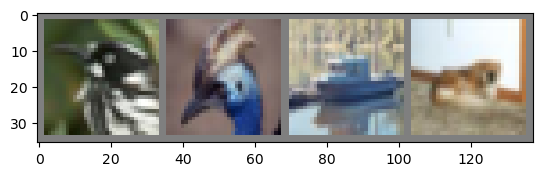

Labels:  bird  bird  ship  dog  


In [17]:
# Mostra as primeiras 4 imagens do lote
print("Amostra de imagens de treino:")
imshow(torchvision.utils.make_grid(images[:4]))

# Imprime os labels correspondentes
print('Labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

## 6. Construção do Modelo de IA

A célula abaixo define a arquitetura de uma Rede Neural Convolucional (CNN), um modelo de IA clássico usado para classificação de imagens.

https://www.deeplearningbook.com.br/introducao-as-redes-neurais-convolucionais/

De forma resumida, ele é dividido em duas partes:

**__init__(self) (A "Planta" da Rede):**

- Esta função é o "construtor" que declara todas as camadas (as "peças") que a rede irá usar.

- self.conv1 e self.conv2: São camadas convolucionais que atuam como "extratores de características", aprendendo a identificar padrões (como bordas, texturas) na imagem.

- self.pool: É uma camada de pooling que reduz o tamanho da imagem (de 28x28 para 14x14, e de 10x10 para 5x5), tornando o modelo mais eficiente e focado nas características mais importantes.

- self.fc1, fc2, fc3: São camadas lineares (totalmente conectadas) que atuam como o "cérebro" de decisão. Elas recebem as características achatadas (16 * 5 * 5 = 400) e as usam para classificar a imagem. A última camada (fc3) tem 10 saídas, uma para cada categoria final (ex: "gato", "cachorro", "avião", etc.).

**forward(self, x) (A "Linha de Montagem"):**

- Esta função define a ordem exata em que os dados (x, a imagem de entrada) passam pelas camadas.

- O fluxo é: Convolução 1 -> Ativação ReLU -> Pooling -> Convolução 2 -> Ativação ReLU -> Pooling.

- Após extrair as características, os dados são "achatados" (flatten) para se tornarem um vetor longo.

- Esse vetor passa pelas camadas de decisão (fc1, fc2, fc3) para produzir o resultado final da classificação.

In [18]:
# Classe para criar a arquitetura do modelo
class ConvNet(nn.Module):

    # Método construtor
    def __init__(self):

        # Inicializa o construtor da classe mãe
        super(ConvNet, self).__init__()

        # Input: 3 canais de cor, Output: 6 feature maps, Kernel: 5x5
        self.conv1 = nn.Conv2d(3, 6, 5)

        # Max pooling 2x2
        self.pool = nn.MaxPool2d(2, 2)

        # Input: 6 canais (do conv1), Output: 16 feature maps, Kernel: 5x5
        self.conv2 = nn.Conv2d(6, 16, 5)

        # As imagens CIFAR-10 são 32x32
        # Após conv1 (5x5): 32-5+1 = 28 -> 28x28
        # Após pool1 (2x2): 28/2 = 14 -> 14x14
        # Após conv2 (5x5): 14-5+1 = 10 -> 10x10
        # Após pool2 (2x2): 10/2 = 5 -> 5x5
        # Tamanho achatado (flattened): 16 canais * 5 * 5 = 400 atributos

        # Camadas totalmente conectadas (Linear)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 400 -> 120
        self.fc2 = nn.Linear(120, 84)         # 120 -> 84
        self.fc3 = nn.Linear(84, 10)          # 84 -> 10 (10 classes)

    # Método forward (passada para a frente)
    def forward(self, x):

        # Aplicando as camadas convolucionais e pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Achatar (flatten) o tensor para a camada linear
        # Achata todas as dimensões, exceto o batch
        x = torch.flatten(x, 1)

        # Aplicando as camadas lineares com ReLU
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Camada de saída (sem ativação, pois a CrossEntropyLoss aplica Softmax)
        x = self.fc3(x)

        return x

In [19]:
# Vamos instanciar o modelo e movê-lo para a CPU para visualizarmos um resumo do modelo
modelo_dsa = ConvNet().to("cpu")

In [20]:
print("Arquitetura do Modelo:")
print(modelo_dsa)

Arquitetura do Modelo:
ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [21]:
# Sumário
summary(modelo_dsa, (3, 32, 32), device = "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [22]:
# Agora instanciamos o modelo e movemos para o dispositivo de treino (GPU/CPU)
modelo_dsa = ConvNet().to(device)

In [23]:
print(device)

cpu


## 7. Definindo a Função de Perda e Otimizador (Backpropagation)

Esta é a função de perda (ou "critério"). Ela atua como uma "régua" que mede o quão distante as previsões do seu modelo estão das respostas corretas.

Em problemas de classificação (como "gato" vs "cachorro" vs "avião"), CrossEntropyLoss é a métrica padrão. Durante o treinamento, ela calcula um único número (a "perda") que indica o tamanho do erro. O objetivo de todo o treinamento é minimizar esse número.

In [24]:
# Define a função de perda. O modelo vai buscar os parâmetros que reduzem o erro geral das previsões.
criterion = nn.CrossEntropyLoss()

Este é o otimizador. Se a função de perda é a "régua" que mede o erro, o otimizador é o "mecânico" que corrige o erro.

O otimizador "olha" para o erro (calculado pela criterion) e decide exatamente como ajustar cada parâmetro (peso) dentro do modelo_dsa.parameters() para reduzir esse erro no próximo passo.

Adam é um algoritmo de otimização moderno e muito popular porque é eficiente e se ajusta automaticamente (adaptativo), funcionando bem na maioria dos casos sem exigir muito ajuste manual. O lr = learning_rate apenas diz a ele o quão "agressivo" deve ser esse ajuste.

In [25]:
# Otimizador Adam
optimizer = optim.Adam(modelo_dsa.parameters(), lr = learning_rate)

## 8. Treinamento do Modelo

A célula abaixo é o "coração" do processo de treinamento e validação do seu modelo de IA. De forma resumida, ele faz o seguinte:

Loop Principal de Épocas (for epoch...): Este é o loop externo. Ele faz o modelo "estudar" o conjunto de dados de treinamento inteiro várias vezes (o número de vezes é definido por num_epochs).
<!-- Trabalho Desenvolvido no Curso da Data Science Academy - www.datascienceacademy.com.br -->
Dentro de cada "Época", existem duas fases:

**1. Fase de Treinamento (modelo_dsa.train())**

Nesta fase, o modelo aprende com os dados:

- for i, (images, labels)...: Pega os dados de treino em pequenos lotes (ex: 64 imagens de cada vez).

- images.to(device): Move os dados para a GPU para processamento rápido.

- outputs = modelo_dsa(images): (Forward) Faz as previsões do modelo para o lote de imagens.

- loss = criterion(...): Calcula o "erro" (quão ruins foram as previsões) comparando outputs com os rótulos corretos (labels).

- optimizer.zero_grad(): Limpa os cálculos de erro da etapa anterior.

- loss.backward(): (Backward) Calcula "para trás" como cada peso do modelo contribuiu para esse erro (calcula os gradientes).

- optimizer.step(): Usa o otimizador (Adam) para ajustar todos os pesos do modelo e reduzir o erro.

**2. Fase de Avaliação (modelo_dsa.eval())**

Após estudar os dados de treino uma vez, o modelo "faz uma prova" para ver o que aprendeu:

- modelo_dsa.eval(): Coloca o modelo em modo de avaliação (desliga recursos como dropout).

- with torch.no_grad(): Desativa o cálculo de gradientes (pois não vamos treinar), o que economiza muita memória e acelera o processo.

- for val_images, val_labels...: Pega os dados do conjunto de teste (dados que o modelo nunca viu no treino).

- val_outputs = modelo_dsa(val_images): Faz previsões sobre os dados de teste.

- n_correct += ...: Compara as previsões do modelo com as respostas corretas e conta o número total de acertos.

**3. Relatório de Progresso**

- print(f'Epoch ...'): No final de cada época, ele imprime um resumo: o erro médio do treinamento e a acurácia (percentual de acertos) no teste, permitindo que você veja o modelo melhorar ao longo do tempo.

In [26]:
%%time

print("\nIniciando o treinamento...\n")

# Calcula o total de passos por época (número de batches)
n_total_steps = len(dsa_loader_treino)

# Loop principal de treinamento
for epoch in range(num_epochs):

    # Coloca o modelo em modo de treinamento
    modelo_dsa.train()

    # Inicializa o acumulador de perda
    running_loss = 0.0

    # Itera sobre os batches do conjunto de treino
    for i, (images, labels) in enumerate(dsa_loader_treino):

        # Move os tensores (imagens e rótulos) para o dispositivo (CPU ou GPU), próximos do modelo
        images = images.to(device)
        labels = labels.to(device)

        # Passagem para frente (forward)
        # Aqui ocorre a previsão do modelo
        outputs = modelo_dsa(images)

        # Calcula o erro do modelo
        loss = criterion(outputs, labels)

        # Zera os gradientes acumulados de iterações anteriores
        optimizer.zero_grad()

        # Calcula os gradientes via backpropagation
        loss.backward()

        # Atualiza os pesos do modelo
        optimizer.step()

        # Soma o valor da perda para cálculo médio posterior
        running_loss += loss.item()

    # Após cada época, avalia o modelo no conjunto de teste (validação)
    # Coloca o modelo em modo de avaliação
    modelo_dsa.eval()

    # Desativa o cálculo de gradientes para economizar memória e tempo
    with torch.no_grad():

        n_correct = 0   # Contador de acertos
        n_samples = 0   # Contador de amostras

        # Loop sobre o conjunto de teste
        for val_images, val_labels in dsa_loader_teste:

            # Move imagens e rótulos para o dispositivo
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            # Faz a inferência no conjunto de teste
            val_outputs = modelo_dsa(val_images)

            # torch.max retorna (valor, índice) → pegamos o índice da classe prevista
            _, predicted = torch.max(val_outputs.data, 1)

            # Incrementa o total de amostras
            n_samples += val_labels.size(0)

            # Incrementa o número de acertos
            n_correct += (predicted == val_labels).sum().item()

    # Calcula a acurácia e a perda média da época
    acc = 100.0 * n_correct / n_samples
    avg_loss = running_loss / n_total_steps

    # Exibe métricas de desempenho para a época atual
    print(f'Epoch [{epoch+1}/{num_epochs}], Erro em Treino: {avg_loss:.4f}, Acurácia em Teste: {acc:.2f} %')

# Exibe mensagem final de conclusão
print('\nTreinamento finalizado.\n')


Iniciando o treinamento...

Epoch [1/10], Erro em Treino: 1.6487, Acurácia em Teste: 47.49 %
Epoch [2/10], Erro em Treino: 1.3602, Acurácia em Teste: 53.26 %
Epoch [3/10], Erro em Treino: 1.2363, Acurácia em Teste: 55.92 %
Epoch [4/10], Erro em Treino: 1.1479, Acurácia em Teste: 59.26 %
Epoch [5/10], Erro em Treino: 1.0823, Acurácia em Teste: 60.32 %
Epoch [6/10], Erro em Treino: 1.0287, Acurácia em Teste: 60.89 %
Epoch [7/10], Erro em Treino: 0.9801, Acurácia em Teste: 61.94 %
Epoch [8/10], Erro em Treino: 0.9397, Acurácia em Teste: 60.71 %
Epoch [9/10], Erro em Treino: 0.9038, Acurácia em Teste: 63.66 %
Epoch [10/10], Erro em Treino: 0.8617, Acurácia em Teste: 63.78 %

Treinamento finalizado.

CPU times: user 9min 44s, sys: 1.18 s, total: 9min 45s
Wall time: 2min 10s


## 9. Avaliação do Modelo

Este bloco de código é responsável por executar a avaliação final do modelo usando o conjunto de dados de teste, que ele nunca viu durante o treinamento. Primeiramente, modelo_dsa.eval() coloca a rede em "modo de avaliação", o que desativa camadas específicas de treino (como dropout). Em seguida, with torch.no_grad() desativa o cálculo de gradientes, pois o modelo não está mais aprendendo; isso economiza memória e acelera muito o processo de inferência.

O código então itera por todos os lotes do dsa_loader_teste. Para cada lote, ele faz as previsões (outputs), usa torch.max para extrair a classe com a maior pontuação (a previsão final, predicted), e compara com os rótulos verdadeiros (labels). Ele acumula o número total de amostras (n_samples) e o número total de acertos (n_correct) para calcular a acurácia geral do modelo.

Simultaneamente, o loop interno (for i in range(len(labels))) realiza uma análise mais detalhada. Ele verifica o resultado de cada imagem individualmente para calcular a acurácia por classe, preenchendo as listas n_class_correct e n_class_samples. Ao final, o script imprime a acurácia geral (ex: 85%) e, em seguida, detalha a performance para cada classe específica (ex: Acurácia da classe 'gato': 90%, Acurácia da classe 'cachorro': 75%), permitindo uma análise mais profunda de onde o modelo está acertando ou errando.

In [27]:
# Coloca o modelo em modo de avaliação
modelo_dsa.eval()

# Desativa o cálculo de gradientes (não é necessário durante a avaliação)
with torch.no_grad():

    # Inicializa contador de acertos totais
    n_correct = 0

    # Inicializa contador total de amostras
    n_samples = 0

    # Lista para contar acertos por classe
    n_class_correct = [0 for _ in range(10)]

    # Lista para contar total de amostras por classe
    n_class_samples = [0 for _ in range(10)]

    # Loop sobre o conjunto de teste
    for images, labels in dsa_loader_teste:

        # Move imagens para o dispositivo (CPU ou GPU)
        images = images.to(device)

        # Move rótulos para o mesmo dispositivo
        labels = labels.to(device)

        # Faz a inferência com o modelo
        outputs = modelo_dsa(images)

        # Obtém as classes com maior probabilidade
        _, predicted = torch.max(outputs, 1)

        # Incrementa o número total de amostras
        n_samples += labels.size(0)

        # Incrementa o número total de acertos
        n_correct += (predicted == labels).sum().item()

        # Calcular acurácia por classe
        for i in range(len(labels)):

            # Obtém o rótulo verdadeiro
            label = labels[i]

            # Obtém o rótulo previsto
            pred = predicted[i]

            # Se acertou, incrementa o contador da classe
            if (label == pred):
                n_class_correct[label] += 1

            # Incrementa o total de amostras da classe
            n_class_samples[label] += 1

    # Calcula a acurácia geral do modelo
    acc_geral = 100.0 * n_correct / n_samples

    # Exibe o resultado da acurácia geral
    print(f'Acurácia geral do modelo na base de teste: {acc_geral:.2f} %')

    # Imprime linha separadora
    print("-" * 30)

    # Loop para calcular e exibir acurácia de cada classe
    for i in range(10):

        # Se houver amostras para a classe
        if n_class_samples[i] > 0:

            # Calcula a acurácia da classe
            acc_classe = 100.0 * n_class_correct[i] / n_class_samples[i]

            # Exibe acurácia da classe
            print(f'Acurácia da classe {classes[i]}: {acc_classe:.2f} %')

        # Caso não existam amostras da classe
        else:

            # Indica ausência de dados para a classe
            print(f'Acurácia da classe {classes[i]}: N/A (sem amostras)')

Acurácia geral do modelo na base de teste: 63.78 %
------------------------------
Acurácia da classe plane: 72.00 %
Acurácia da classe car: 79.70 %
Acurácia da classe bird: 48.70 %
Acurácia da classe cat: 32.00 %
Acurácia da classe deer: 58.20 %
Acurácia da classe dog: 50.00 %
Acurácia da classe frog: 76.30 %
Acurácia da classe horse: 74.20 %
Acurácia da classe ship: 82.20 %
Acurácia da classe truck: 64.50 %


Vamos salvar o modelo em disco.

In [28]:
PATH = './modelo_dsa_mp7.pth'
torch.save(modelo_dsa.state_dict(), PATH)
print(f'Modelo salvo em: {PATH}')

Modelo salvo em: ./modelo_dsa_mp7.pth


## 10. Deploy e Uso do Modelo

In [29]:
# Cria uma nova instância do modelo
model_carregado = ConvNet().to(device)

In [30]:
# Carrega os pesos (state_dict) salvos
model_carregado.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [31]:
# IMPORTANTE: Colocar o modelo em modo de avaliação
model_carregado.eval()

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [32]:
# Definir a transformação para imagens de inferência
# Deve ser a MESMA transformação usada no treino/teste
# (Exceto por augmentations, que não usamos aqui)
inference_transform = transforms.Compose([
    transforms.Resize((32, 32)), # Garantir que a imagem tenha 32x32
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [33]:
# Cria a função de deploy
def dsa_ia_classifica_imagem(image_path, model):

    """
    Carrega uma imagem de um caminho local, aplica as transformações
    e faz a predição usando o modelo treinado.
    """

    try:
        # Carregar imagem do caminho local
        img_pil = Image.open(image_path).convert('RGB')
    except Exception as e:
        print(f"Erro ao carregar imagem local {image_path}: {e}")
        return

    # Aplicar transformações
    img_tensor = inference_transform(img_pil)

    # O modelo espera um lote (batch). Adicionamos uma dimensão extra [B, C, H, W]
    img_tensor = img_tensor.unsqueeze(0).to(device)

    # Fazer a predição
    model.eval() # Garantir que o modelo está em modo de avaliação
    with torch.no_grad():

        outputs = model(img_tensor)

        probabilities = F.softmax(outputs, dim=1)

        # Obter a classe com maior probabilidade
        _, predicted_idx = torch.max(outputs, 1)

    classe_predita = classes[predicted_idx.item()]

    confianca = torch.max(probabilities).item() * 100

    # Mostrar a imagem e a predição
    plt.imshow(img_pil)

    # Usamos rf'...' (raw f-string) e $\bf{...}$ para negrito
    plt.title(rf'Classe Prevista Pelo Modelo: $\bf{{{classe_predita}}}$ (Confiança: {confianca:.2f}%)')
    plt.axis('off')
    plt.show()

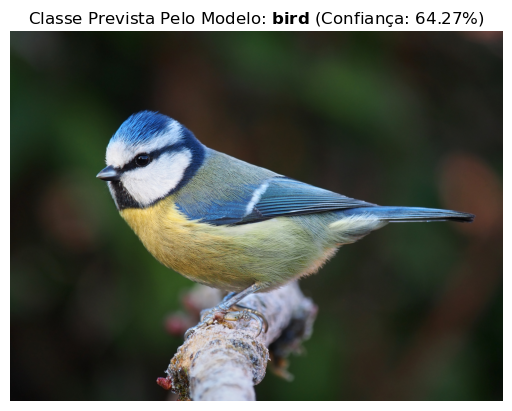

In [34]:
# Usamos o modelo para classificar a imagem
dsa_ia_classifica_imagem("imagem1.jpg", model_carregado)

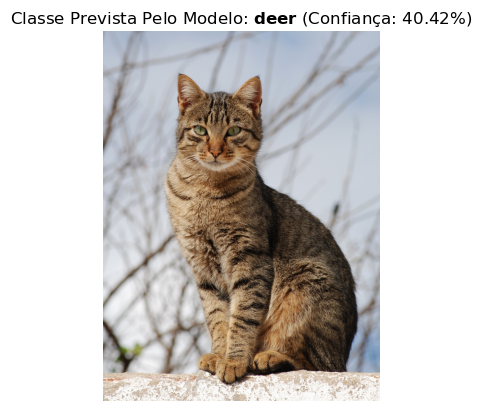

In [35]:
# Usamos o modelo para classificar a imagem
dsa_ia_classifica_imagem("imagem2.jpg", model_carregado)

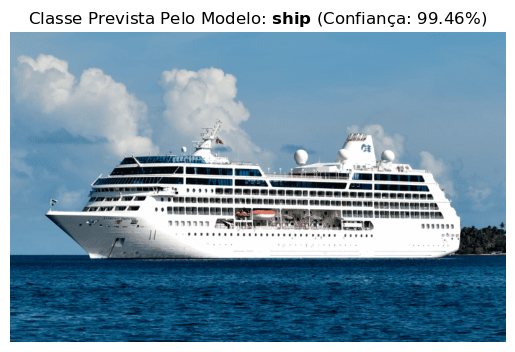

In [36]:
# Usamos o modelo para classificar a imagem
dsa_ia_classifica_imagem("imagem3.png", model_carregado)

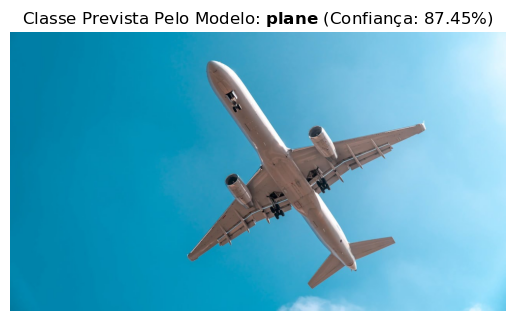

In [37]:
# Usamos o modelo para classificar a imagem
dsa_ia_classifica_imagem("imagem4.jpg", model_carregado)

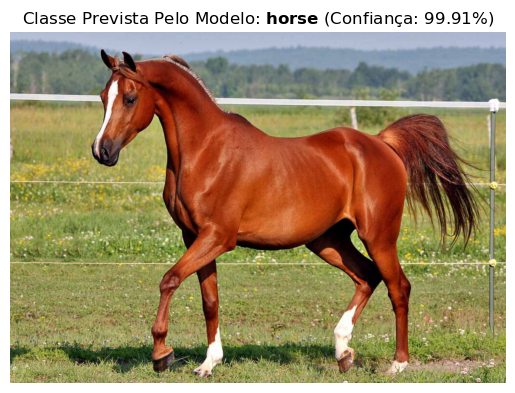

In [38]:
# Usamos o modelo para classificar a imagem
dsa_ia_classifica_imagem("imagem5.jpg", model_carregado)

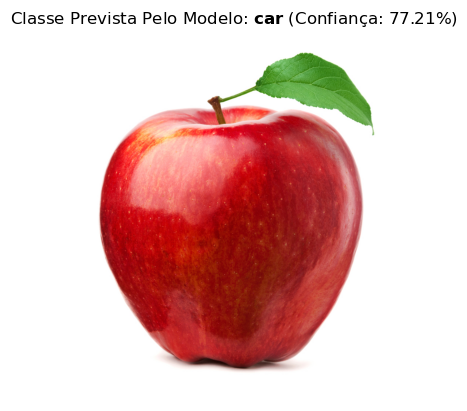

In [39]:
# Usamos o modelo para classificar a imagem (observe que o modelo não foi treinado com imagens de maçãs)
dsa_ia_classifica_imagem("imagem6.jpg", model_carregado)

## Bônus - Comparando a Execução em Diferentes Tipos de Hardware

O objetivo aqui é apenas ter uma ideia geral da diferença de hardware no treinamento do modelo.

- 1- Apple M4 Max com GPU - 45.4 s
- 2- Apple M4 Max sem GPU - 1min 40s
- 3- Google Colab com GPU A100 (High RAM) - 2min 33s
- 4- Google Colab com GPU A100 - 2min 34s
- 5- Google Colab com GPU T4 - 2min 32s
- 6- Google Colab com CPU - 3min 34s

# Fim